In [ ]:
!pip install catboost
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier

In [ ]:
class_data = pd.read_csv('/content/classData[1].csv')

x = class_data[["Ia","Ib","Ic","Va","Vb","Vc"]]
y = class_data[["G", "C", "B", "A"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)

x_test_scaled = scaler.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)


In [ ]:
models_cat = {}

for label in y_train.columns:
    print(f"Training model for label: {label}")
    model = CatBoostClassifier(iterations=100, depth=8, learning_rate=0.1,
                               loss_function='Logloss',
                               custom_metric=['AUC'], random_seed=42, verbose=0)
    model.fit(x_train_scaled, y_train[label])
    models_cat[label] = model

Training model for label: G
Training model for label: C
Training model for label: B
Training model for label: A


In [ ]:
import xgboost as xgb
models_xg = {}
for label in y.columns:
    y_train_label = y_train[label]
    y_test_label = y_test[label]
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        random_state=42,
        objective='binary:logistic',
        eval_metric='logloss',
        subsample=0.8,
        colsample_bytree=0.8,

    )

    model.fit(x_train_scaled, y_train_label)
    models_xg[label] = model



In [ ]:
import lightgbm as lgb

models_lgb = {}
for label in y.columns:
    print(f"Training LightGBM model for label: {label}")
    y_train_label = y_train[label]
    y_test_label = y_test[label]

    model = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        objective='binary',
        metric='logloss',
        subsample=0.8,
        colsample_bytree=0.8
    )

    model.fit(x_train_scaled, y_train_label)
    models_lgb[label] = model

In [ ]:
from sklearn.metrics import accuracy_score

print('==============XGB=============')
for label, model in models_xg.items():
  y_pred = model.predict(x_test_scaled)
  y_pred_P = model.predict_proba(x_test_scaled)

  acc = accuracy_score(y_test[label], y_pred)
  print(f"XGB Accuracy for label {label}: {acc:.2f}")

print('==============CAT=============')
for label, model in models_cat.items():
  y_pred = model.predict(x_test_scaled)
  y_pred_P = model.predict_proba(x_test_scaled)

  acc = accuracy_score(y_test[label], y_pred)
  print(f"Cat Accuracy for label {label}: {acc:.2f}")

print('==============LGB=============')
for label, model in models_lgb.items():
  y_pred = model.predict(x_test_scaled)
  y_pred_P = model.predict_proba(x_test_scaled)

  acc = accuracy_score(y_test[label], y_pred)
  print(f"LGB Accuracy for label {label}: {acc:.2f}")

==============XGB=============
XGB Accuracy for label G: 0.83
XGB Accuracy for label C: 0.99
XGB Accuracy for label B: 0.99
XGB Accuracy for label A: 1.00
==============CAT=============
Cat Accuracy for label G: 0.84
Cat Accuracy for label C: 1.00
Cat Accuracy for label B: 1.00
Cat Accuracy for label A: 1.00
==============LGB=============
LGB Accuracy for label G: 0.83
LGB Accuracy for label C: 1.00
LGB Accuracy for label B: 1.00
LGB Accuracy for label A: 1.00


In [ ]:
from sklearn.linear_model import LogisticRegression

cat_train = pd.DataFrame()
cat_test = pd.DataFrame()
xg_train = pd.DataFrame()
xg_test = pd.DataFrame()
lgb_train = pd.DataFrame()
lgb_test = pd.DataFrame()

for label in y_train.columns:
  cat_train[label] = models_cat[label].predict_proba(x_train_scaled)[:,1]
  cat_test[label] = models_cat[label].predict_proba(x_test_scaled)[:,1]
  xg_train[label] = models_xg[label].predict_proba(x_train_scaled)[:,1]
  xg_test[label] = models_xg[label].predict_proba(x_test_scaled)[:,1]
  lgb_train[label] = models_lgb[label].predict_proba(x_train_scaled)[:,1]
  lgb_test[label] = models_lgb[label].predict_proba(x_test_scaled)[:,1]

  meta_trained = pd.concat([cat_train, xg_train, lgb_train], axis=1)
  meta_test = pd.concat([cat_test, xg_test, lgb_test], axis=1)

meta_models = {}

for label in y_train.columns:
  print(f"Training meta-model for label: {label}")
  meta_model = LogisticRegression(random_state=82)
  meta_model.fit(meta_trained, y_train[label])
  meta_models[label] = meta_model

print('==============Stacked Model=============')
for label, meta_model in meta_models.items():
  stacked_predictions = meta_model.predict(meta_test)
  acc = accuracy_score(y_test[label], stacked_predictions)
  print(f"Stacked Model Accuracy for label {label}: {acc:.4f}")

Training meta-model for label: G
Training meta-model for label: C
Training meta-model for label: B
Training meta-model for label: A
==============Stacked Model=============
Stacked Model Accuracy for label G: 0.8303
Stacked Model Accuracy for label C: 0.9981
Stacked Model Accuracy for label B: 0.9981
Stacked Model Accuracy for label A: 1.0000


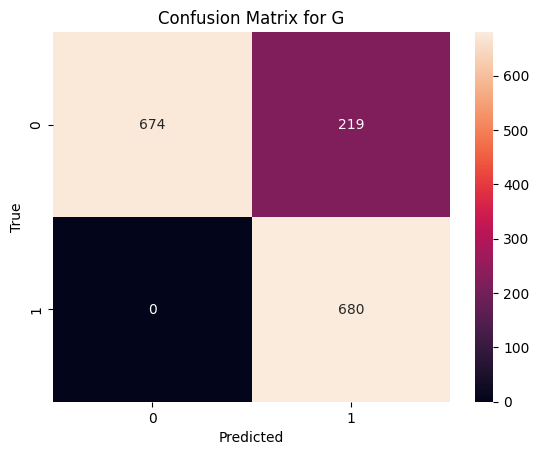

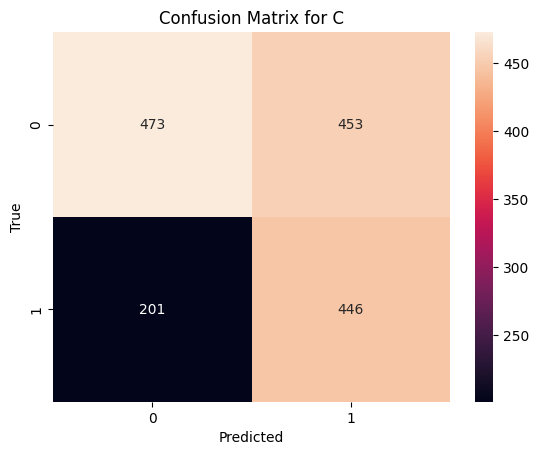

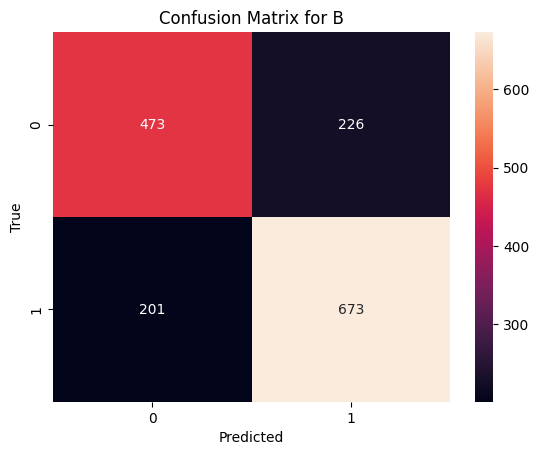

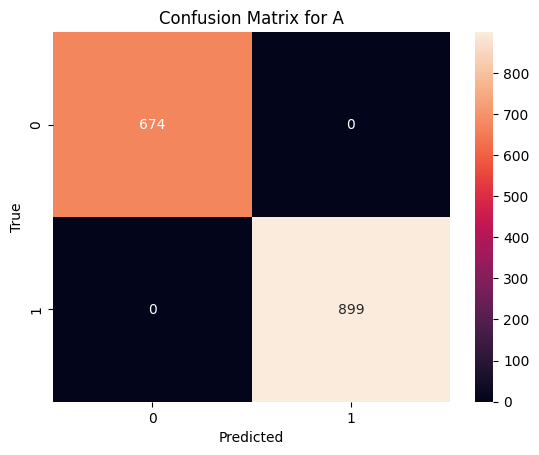

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_c = confusion_matrix(y_test['C'], stacked_predictions)
cm_g = confusion_matrix(y_test['G'], stacked_predictions)
cm_b = confusion_matrix(y_test['B'], stacked_predictions)
cm_a = confusion_matrix(y_test['A'], stacked_predictions)

sns.heatmap(cm_g, annot=True, fmt='d', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix for G')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

sns.heatmap(cm_c, annot=True, fmt='d', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix for C')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

sns.heatmap(cm_b, annot=True, fmt='d', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix for B')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

sns.heatmap(cm_a, annot=True, fmt='d', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix for A')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()